In [1]:

import os
import json
import random
import warnings
from pathlib import Path
from dataclasses import dataclass, asdict

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchaudio
from audiomentations import Compose, AddGaussianNoise, PitchShift, Gain

from transformers import AutoConfig, Wav2Vec2FeatureExtractor, AutoModelForAudioClassification, get_linear_schedule_with_warmup, logging as hf_logging

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

warnings.filterwarnings("ignore", category=UserWarning)
hf_logging.set_verbosity_error() 



In [2]:
@dataclass
class Config:
    # Paths 
    data_dir: str = "data/raw/RAVDEES"
    output_dir: str = "results/outputs/WavLM_SER"

    #  Model 
    model_name: str = "microsoft/wavlm-base-plus"

    # Data & Preprocessing 
    sampling_rate: int = 16000
    max_duration_s: float = 4.0
    seed: int = 42

    #  Training 
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    num_epochs: int = 8
    batch_size: int = 8
    learning_rate_head: float = 5e-4
    learning_rate_backbone: float = 5e-5
    weight_decay: float = 0.01
    num_warmup_steps: int = 50
    n_splits: int = 5

    # Emotion Mapping 
    emotion_map: dict = None

    def __post_init__(self):
        self.emotion_map = {
            "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
            "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
        }
        Path(self.output_dir).mkdir(parents=True, exist_ok=True)


def set_seed(seed):
    """Set seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

config = Config()
set_seed(config.seed)


In [3]:
def get_data_df(data_dir, emotion_map):
    """Scans the data directory and creates a pandas DataFrame."""
    wav_files = sorted(list(Path(data_dir).rglob("*.wav")))
    if not wav_files:
        raise FileNotFoundError(f"No .wav files found in {data_dir}.")

    data = []
    for path in wav_files:
        try:
            parts = path.stem.split("-")
            emotion_code = parts[2]
            actor_id = int(parts[-1])
            emotion_name = emotion_map.get(emotion_code, "unknown")
            data.append({"path": str(path), "emotion": emotion_name, "actor": actor_id})
        except (IndexError, ValueError):
            print(f"Could not parse metadata from: {path.name}")
            continue
    return pd.DataFrame(data)

# Create DataFrame
df = get_data_df(config.data_dir, config.emotion_map)

# Create label mappings
id_to_label = {i: label for i, label in enumerate(sorted(df['emotion'].unique()))}
label_to_id = {v: k for k, v in id_to_label.items()}
df['label'] = df['emotion'].map(label_to_id)
config.num_labels = len(label_to_id)

print(f"Found {len(df)} audio files.")
print("Label mapping:", label_to_id)

# Create Splits
sgkf = StratifiedGroupKFold(n_splits=config.n_splits, shuffle=True, random_state=config.seed)
splits = list(sgkf.split(df, df['label'], df['actor']))

train_idx, val_idx = splits[0]
_, test_idx = splits[1] # Use a different fold for the test set to ensure no overlap

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df = df.iloc[val_idx].reset_index(drop=True)
test_df = df.iloc[test_idx].reset_index(drop=True)

print(f"Train samples: {len(train_df)} | Validation samples: {len(val_df)} | Test samples: {len(test_df)}")


Found 1440 audio files.
Label mapping: {'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}
Train samples: 1140 | Validation samples: 300 | Test samples: 300


In [4]:
def get_augmentations(variety: str):
    """Returns an augmentation pipeline based on the variety."""
    if variety == "strong_aug":
        return Compose([
            AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
            PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
            Gain(min_gain_db=-12, max_gain_db=12, p=0.5), 
        ])
    return None

class AudioDataset(Dataset):
    def __init__(self, df, feature_extractor, config, augmentations=None):
        self.df = df
        self.feature_extractor = feature_extractor
        self.target_sr = config.sampling_rate
        self.max_len = int(config.max_duration_s * self.target_sr)
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['path']
        label = row['label']

        try:
            wav, sr = torchaudio.load(path)
            if wav.shape[0] > 1:
                wav = torch.mean(wav, dim=0, keepdim=True)
            if sr != self.target_sr:
                resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.target_sr)
                wav = resampler(wav)

            if self.augmentations:
                wav_np = wav.squeeze().numpy()
                wav_aug = self.augmentations(samples=wav_np, sample_rate=self.target_sr)
                wav = torch.from_numpy(wav_aug).unsqueeze(0)

            if wav.shape[1] > self.max_len:
                wav = wav[:, :self.max_len]
            else:
                padding = self.max_len - wav.shape[1]
                wav = nn.functional.pad(wav, (0, padding))

            features = self.feature_extractor(wav.squeeze().numpy(), sampling_rate=self.target_sr, return_tensors="pt")
            input_values = features.input_values.squeeze(0)

            return {"input_values": input_values, "label": torch.tensor(label, dtype=torch.long)}

        except Exception as e:
            # Fallback for corrupted files
            print(f"Error loading or processing file {path}: {e}")
            return self.__getitem__((idx + 1) % len(self))



In [5]:

def build_model(config, fine_tuning_mode):
    model_config = AutoConfig.from_pretrained(
        config.model_name,
        num_labels=config.num_labels,
        label2id=label_to_id,
        id2label=id_to_label,
    )
    model = AutoModelForAudioClassification.from_pretrained(config.model_name, config=model_config)

    for param in model.parameters():
        param.requires_grad = False

    if fine_tuning_mode == 'feature_extract':
        for param in model.classifier.parameters():
            param.requires_grad = True
    elif fine_tuning_mode == 'full_finetune':
        for param in model.parameters():
            param.requires_grad = True
    else:
        raise ValueError(f"Invalid fine_tuning_mode: {fine_tuning_mode}")
    return model

def train_one_epoch(model, loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    all_preds, all_labels = [], []

    for batch in tqdm(loader, desc="Training"):
        optimizer.zero_grad()
        input_values = batch['input_values'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_values, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()

        total_loss += loss.item() * labels.size(0)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    return avg_loss, acc, f1

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_values = batch['input_values'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_values, labels=labels)
            loss = outputs.loss

            total_loss += loss.item() * labels.size(0)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    return avg_loss, acc, f1, all_labels, all_preds



In [6]:
def run_experiment(variety_name: str, fine_tuning_mode: str, augmentation_type: str, config: Config):
    print(f"\n{'='*20} RUNNING EXPERIMENT: {variety_name} {'='*20}")

    set_seed(config.seed)
    variety_output_dir = Path(config.output_dir) / variety_name
    variety_output_dir.mkdir(parents=True, exist_ok=True)

    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(config.model_name)
    augmentations = get_augmentations(augmentation_type)

    train_ds = AudioDataset(train_df, feature_extractor, config, augmentations=augmentations)
    val_ds = AudioDataset(val_df, feature_extractor, config, augmentations=None)

    train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=config.batch_size, shuffle=False, num_workers=0)

    model = build_model(config, fine_tuning_mode).to(config.device)

    optimizer_grouped_parameters = [
        {"params": [p for n, p in model.named_parameters() if "classifier" in n and p.requires_grad], "lr": config.learning_rate_head},
        {"params": [p for n, p in model.named_parameters() if "classifier" not in n and p.requires_grad], "lr": config.learning_rate_backbone},
    ]
    optimizer = torch.optim.AdamW(optimizer_grouped_parameters, weight_decay=config.weight_decay)

    num_training_steps = len(train_loader) * config.num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=config.num_warmup_steps, num_training_steps=num_training_steps)

    best_val_f1 = -1
    history = []

    for epoch in range(1, config.num_epochs + 1):
        print(f"\n--- Epoch {epoch}/{config.num_epochs} ---")
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, scheduler, config.device)
        val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, config.device)

        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} F1: {train_f1:.3f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.3f} F1: {val_f1:.3f}")

        epoch_results = {
            'epoch': epoch,
            'train_loss': train_loss, 'train_acc': train_acc, 'train_f1': train_f1,
            'val_loss': val_loss, 'val_acc': val_acc, 'val_f1': val_f1
        }
        history.append(epoch_results)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            print(f"New best model found with F1 Score of: {best_val_f1:.4f}. Saving model...")
            torch.save(model.state_dict(), variety_output_dir / "best_model.pt")

    results = {
        "variety_name": variety_name,
        "best_val_f1": best_val_f1,
        "config": asdict(config),
        "history": history
    }
    with open(variety_output_dir / "results.json", "w") as f:
        json.dump(results, f, indent=2)
    return results




==================== RUNNING EXPERIMENT: V1_Feature_Extraction ====================


2025-10-21 01:43:17.216058: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-21 01:43:17.460080: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-21 01:43:19.075090: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.



--- Epoch 1/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 01 | Train Loss: 2.0692 Acc: 0.168 F1: 0.090 | Val Loss: 2.0563 Acc: 0.293 F1: 0.155
New best model found with F1 Score of: 0.1550. Saving model...

--- Epoch 2/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 02 | Train Loss: 2.0496 Acc: 0.279 F1: 0.168 | Val Loss: 2.0416 Acc: 0.323 F1: 0.208
New best model found with F1 Score of: 0.2082. Saving model...

--- Epoch 3/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 03 | Train Loss: 2.0386 Acc: 0.324 F1: 0.263 | Val Loss: 2.0315 Acc: 0.377 F1: 0.290
New best model found with F1 Score of: 0.2902. Saving model...

--- Epoch 4/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 04 | Train Loss: 2.0294 Acc: 0.329 F1: 0.267 | Val Loss: 2.0238 Acc: 0.380 F1: 0.285

--- Epoch 5/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 05 | Train Loss: 2.0230 Acc: 0.362 F1: 0.298 | Val Loss: 2.0180 Acc: 0.413 F1: 0.321
New best model found with F1 Score of: 0.3215. Saving model...

--- Epoch 6/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 06 | Train Loss: 2.0172 Acc: 0.379 F1: 0.326 | Val Loss: 2.0139 Acc: 0.403 F1: 0.320

--- Epoch 7/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 07 | Train Loss: 2.0141 Acc: 0.361 F1: 0.298 | Val Loss: 2.0113 Acc: 0.407 F1: 0.315

--- Epoch 8/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 08 | Train Loss: 2.0116 Acc: 0.370 F1: 0.306 | Val Loss: 2.0105 Acc: 0.407 F1: 0.317

==================== RUNNING EXPERIMENT: V2_Full_Finetune_LightAug ====================

--- Epoch 1/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 01 | Train Loss: 1.9466 Acc: 0.218 F1: 0.157 | Val Loss: 1.6419 Acc: 0.363 F1: 0.237
New best model found with F1 Score of: 0.2368. Saving model...

--- Epoch 2/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 02 | Train Loss: 1.4379 Acc: 0.442 F1: 0.381 | Val Loss: 1.2503 Acc: 0.510 F1: 0.408
New best model found with F1 Score of: 0.4084. Saving model...

--- Epoch 3/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 03 | Train Loss: 0.9319 Acc: 0.665 F1: 0.633 | Val Loss: 0.9317 Acc: 0.673 F1: 0.660
New best model found with F1 Score of: 0.6599. Saving model...

--- Epoch 4/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 04 | Train Loss: 0.6024 Acc: 0.803 F1: 0.791 | Val Loss: 0.8424 Acc: 0.730 F1: 0.718
New best model found with F1 Score of: 0.7183. Saving model...

--- Epoch 5/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 05 | Train Loss: 0.3319 Acc: 0.904 F1: 0.899 | Val Loss: 0.8130 Acc: 0.770 F1: 0.759
New best model found with F1 Score of: 0.7588. Saving model...

--- Epoch 6/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 06 | Train Loss: 0.1899 Acc: 0.952 F1: 0.949 | Val Loss: 1.1718 Acc: 0.717 F1: 0.707

--- Epoch 7/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 07 | Train Loss: 0.1298 Acc: 0.969 F1: 0.969 | Val Loss: 1.1023 Acc: 0.710 F1: 0.706

--- Epoch 8/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 08 | Train Loss: 0.0860 Acc: 0.984 F1: 0.984 | Val Loss: 1.1037 Acc: 0.723 F1: 0.715

==================== RUNNING EXPERIMENT: V3_Full_Finetune_StrongAug ====================

--- Epoch 1/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 01 | Train Loss: 2.0597 Acc: 0.158 F1: 0.125 | Val Loss: 2.0681 Acc: 0.133 F1: 0.029
New best model found with F1 Score of: 0.0294. Saving model...

--- Epoch 2/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 02 | Train Loss: 2.0661 Acc: 0.125 F1: 0.105 | Val Loss: 2.0695 Acc: 0.133 F1: 0.029

--- Epoch 3/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 03 | Train Loss: 2.0466 Acc: 0.163 F1: 0.117 | Val Loss: 2.0630 Acc: 0.133 F1: 0.029

--- Epoch 4/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 04 | Train Loss: 2.0699 Acc: 0.124 F1: 0.100 | Val Loss: 2.0621 Acc: 0.133 F1: 0.029

--- Epoch 5/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 05 | Train Loss: 2.0660 Acc: 0.129 F1: 0.096 | Val Loss: 2.0639 Acc: 0.133 F1: 0.029

--- Epoch 6/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 06 | Train Loss: 2.0665 Acc: 0.122 F1: 0.080 | Val Loss: 2.0616 Acc: 0.133 F1: 0.029

--- Epoch 7/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 07 | Train Loss: 2.0634 Acc: 0.123 F1: 0.075 | Val Loss: 2.0612 Acc: 0.133 F1: 0.029

--- Epoch 8/8 ---


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 08 | Train Loss: 2.0620 Acc: 0.132 F1: 0.069 | Val Loss: 2.0613 Acc: 0.133 F1: 0.029

==================== MODEL COMPARISON & ANALYSIS ====================

--- Summary of Best Performance for Each Variety ---
                            Val F1-Score  Val Accuracy  Train F1-Score  \
Variety                                                                  
V1 Feature Extraction           0.321454      0.413333        0.298121   
V2 Full Finetune LightAug       0.758787      0.770000        0.899179   
V3 Full Finetune StrongAug      0.029412      0.133333        0.124615   

                            Best Epoch  
Variety                                 
V1 Feature Extraction                5  
V2 Full Finetune LightAug            5  
V3 Full Finetune StrongAug           1  


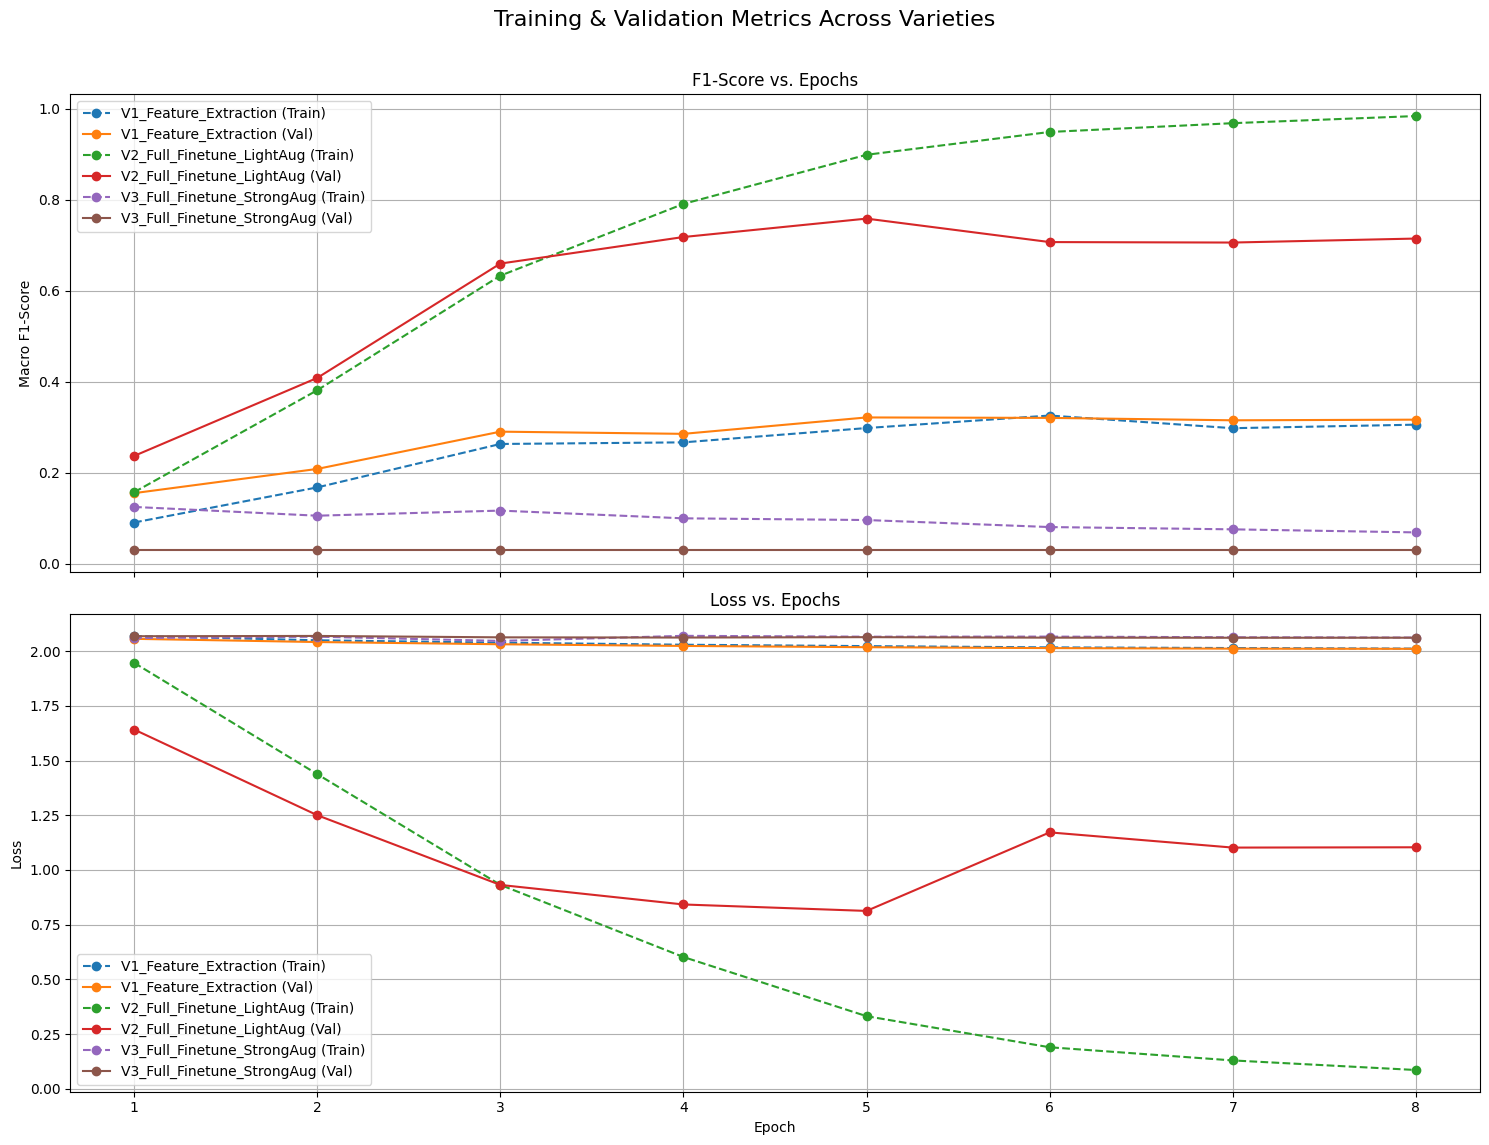


--- Conclusion ---
The best performing model variety is 'V2 Full Finetune LightAug' with a validation Macro F1-Score of 0.7588.
This indicates that the chosen strategy provided the best generalization on unseen validation data.


In [7]:
all_results = {}
varieties_to_run = [
    {"name": "V1_Feature_Extraction", "mode": "feature_extract", "aug": "none"},
    {"name": "V2_Full_Finetune_LightAug", "mode": "full_finetune", "aug": "none"},
    {"name": "V3_Full_Finetune_StrongAug", "mode": "full_finetune", "aug": "strong_aug"},
]

for var in varieties_to_run:
    results = run_experiment(var["name"], var["mode"], var["aug"], config)
    all_results[var["name"]] = results

print(f"\n{'='*20} MODEL COMPARISON & ANALYSIS {'='*20}")

summary_data = []
for name, res in all_results.items():
    best_epoch_data = max(res['history'], key=lambda x: x['val_f1'])
    summary_data.append({
        "Variety": name.replace("_", " "),
        "Val F1-Score": best_epoch_data['val_f1'],
        "Val Accuracy": best_epoch_data['val_acc'],
        "Train F1-Score": best_epoch_data['train_f1'],
        "Best Epoch": best_epoch_data['epoch']
    })
summary_df = pd.DataFrame(summary_data).set_index("Variety")
print("\n--- Summary of Best Performance for Each Variety ---")
print(summary_df)


fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
fig.suptitle('Training & Validation Metrics Across Varieties', fontsize=16)

# Plot F1 Scores
for name, res in all_results.items():
    history_df = pd.DataFrame(res['history'])
    axes[0].plot(history_df['epoch'], history_df['train_f1'], 'o--', label=f'{name} (Train)')
    axes[0].plot(history_df['epoch'], history_df['val_f1'], 'o-', label=f'{name} (Val)')
axes[0].set_ylabel("Macro F1-Score")
axes[0].set_title("F1-Score vs. Epochs")
axes[0].legend()
axes[0].grid(True)

# Plot Losses
for name, res in all_results.items():
    history_df = pd.DataFrame(res['history'])
    axes[1].plot(history_df['epoch'], history_df['train_loss'], 'o--', label=f'{name} (Train)')
    axes[1].plot(history_df['epoch'], history_df['val_loss'], 'o-', label=f'{name} (Val)')
axes[1].set_ylabel("Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_title("Loss vs. Epochs")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig(Path(config.output_dir) / "all_varieties_training_plots.png")
plt.show()

# --- Conclusion ---
best_variety_name_cleaned = summary_df['Val F1-Score'].idxmax()
best_variety_name = best_variety_name_cleaned.replace(" ", "_")
print(f"\n--- Conclusion ---")
print(f"The best performing model variety is '{best_variety_name_cleaned}' "
      f"with a validation Macro F1-Score of {summary_df['Val F1-Score'].max():.4f}.")
print("This indicates that the chosen strategy provided the best generalization on unseen validation data.")



In [ ]:

print(f"\n{'='*20} FINAL EVALUATION ON TEST SET ({best_variety_name_cleaned}) {'='*20}")

# --- Load the single best model ---
best_model_path = Path(config.output_dir) / best_variety_name / "best_model.pt"
# Determine the mode used for the best model to build it correctly
best_model_mode = [v['mode'] for v in varieties_to_run if v['name'] == best_variety_name][0]

best_model = build_model(config, fine_tuning_mode=best_model_mode).to(config.device)
best_model.load_state_dict(torch.load(best_model_path))

# --- Create Test Loader ---
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(config.model_name)
test_ds = AudioDataset(test_df, feature_extractor, config, augmentations=None)
test_loader = DataLoader(test_ds, batch_size=config.batch_size, shuffle=False, num_workers=0)

# --- Evaluate ---
test_loss, test_acc, test_f1, all_labels, all_preds = evaluate(best_model, test_loader, config.device)

print(f"\n--- Test Set Performance ---")
print(f"Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f} | Macro F1-Score: {test_f1:.4f}")

# --- Classification Report ---
report = classification_report(all_labels, all_preds, target_names=label_to_id.keys(), zero_division=0)
print("\n--- Classification Report ---\n")
print(report)

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_id.keys(), yticklabels=label_to_id.keys())
plt.title(f'Confusion Matrix for {best_variety_name_cleaned} on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(Path(config.output_dir) / f"final_confusion_matrix_{best_variety_name}.png")
plt.show()

print(f"\nAll artifacts saved to: {Path(config.output_dir).resolve()}")